In [9]:
import matplotlib.font_manager as fm
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

[('NanumGothic', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'),
 ('NanumGothicCoding',
  '/usr/share/fonts/truetype/nanum/NanumGothic_Coding_Bold.ttf'),
 ('NanumMyeongjo', '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'),
 ('NanumMyeongjo', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf'),
 ('NanumGothicCoding',
  '/usr/share/fonts/truetype/nanum/NanumGothic_Coding.ttf'),
 ('NanumBarunGothic',
  '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf'),
 ('NanumGothic', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'),
 ('NanumBarunGothic', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')]

loss at step  10 :  6.715085
loss at step  20 :  3.9544728
loss at step  30 :  4.114168
loss at step  40 :  3.4389954
loss at step  50 :  3.054241
loss at step  60 :  3.4453106
loss at step  70 :  3.3980966
loss at step  80 :  3.26345
loss at step  90 :  3.1151161
loss at step  100 :  3.2505631
loss at step  110 :  3.3003678
loss at step  120 :  3.2058175
loss at step  130 :  3.082436
loss at step  140 :  3.2201614
loss at step  150 :  2.8973894
loss at step  160 :  3.021278
loss at step  170 :  3.3028157
loss at step  180 :  3.2314224
loss at step  190 :  2.969789
loss at step  200 :  3.102092
loss at step  210 :  3.2610652
loss at step  220 :  3.058014
loss at step  230 :  3.1064258
loss at step  240 :  3.006927
loss at step  250 :  3.364656
loss at step  260 :  3.0026433
loss at step  270 :  3.2871277
loss at step  280 :  2.892528
loss at step  290 :  3.2824821
loss at step  300 :  2.951805


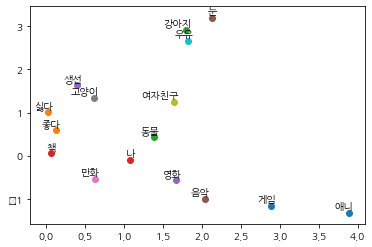

In [12]:
# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# matplot 에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(
                fname="/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # 한글 폰트 위치를 넣어주세요
            ).get_name()
matplotlib.rc('font', family=font_name)

# 단어 벡터를 분석해볼 임의의 문장들
sentences = ["나 고양이 좋다",
             "나 강아지 좋다",
             "나 동물 좋다",
             "강아지 고양이 동물",
             "여자친구 고양이 강아지 좋다",
             "고양이 생선 우유 좋다",
             "강아지 생선 싫다 우유 좋다",
             "강아지 고양이 눈 좋다",
             "나 여자친구 좋다",
             "여자친구 나 싫다",
             "여자친구 나 영화 책 음악 좋다",
             "나 게임 만화 애니 좋다",
             "고양이 강아지 싫다",
             "강아지 고양이 좋다"]

# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dict = {w: i for i, w in enumerate(word_list)}

# 윈도우 사이즈를 1 로 하는 skip-gram 모델을 만듭니다.
# 예) 나 게임 만화 애니 좋다
#   -> ([나, 만화], 게임), ([게임, 애니], 만화), ([만화, 좋다], 애니)
#   -> (게임, 나), (게임, 만화), (만화, 게임), (만화, 애니), (애니, 만화), (애니, 좋다)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    # (context, target) : ([target index - 1, target index + 1], target)
    # 스킵그램을 만든 후, 저장은 단어의 고유 번호(index)로 저장합니다
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])


# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels


#########
# 옵션 설정
######
# 학습을 반복할 횟수
training_epoch = 300
# 학습률
learning_rate = 0.1
# 한 번에 학습할 데이터의 크기
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
# 이 예제에서는 x, y 그래프로 표현하기 쉽게 2 개의 값만 출력하도록 합니다.
embedding_size = 2
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 합니다.
num_sampled = 15
# 총 단어 갯수
voc_size = len(word_list)


#########
# 신경망 모델 구성
######
inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야합니다.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수입니다.
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 갖습니다.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수를 직접 구현하려면 매우 복잡하지만,
# 함수를 텐서플로우가 제공하므로 그냥 tf.nn.nce_loss 함수를 사용하기만 하면 됩니다.
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


#########
# 신경망 모델 학습
######
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})

        if step % 10 == 0:
            print("loss at step ", step, ": ", loss_val)

    # matplot 으로 출력하여 시각적으로 확인해보기 위해
    # 임베딩 벡터의 결과 값을 계산하여 저장합니다.
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()


#########
# 임베딩된 Word2Vec 결과 확인
# 결과는 해당 단어들이 얼마나 다른 단어와 인접해 있는지를 보여줍니다.
######
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()